<h2>Quick Start: Creating Sample-wise Unlearnable Examples</h2>

<h3>Prepare Data</h3>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Prepare Dataset
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root='../datasets', train=False, download=True, transform=test_transform)

clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=512,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)

Files already downloaded and verified
Files already downloaded and verified


<h3>Prepare Model</h3>

In [2]:
from models.ResNet import ResNet18
import toolbox

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)

noise_generator = toolbox.PerturbationTool(epsilon=0.03137254901960784, num_steps=20, step_size=0.0031372549019607846)

<h3>Generate Error-Minimizing Noise</h3>

In [3]:
from tqdm import tqdm

noise = torch.zeros([50000, 3, 32, 32])
data_iter = iter(clean_train_loader)
condition = True
train_idx = 0

while condition:
    # optimize theta for M steps
    base_model.train()
    for param in base_model.parameters():
        param.requires_grad = True
    for j in range(0, 10):
        try:
            (images, labels) = next(data_iter)
        except:
            train_idx = 0
            data_iter = iter(clean_train_loader)
            (images, labels) = next(data_iter)
        
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[train_idx]
            train_idx += 1
        images, labels = images.cuda(), labels.cuda()
        base_model.zero_grad()
        optimizer.zero_grad()
        logits = base_model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(base_model.parameters(), 5.0)
        optimizer.step()
    
    # Perturbation over entire dataset
    idx = 0
    for param in base_model.parameters():
        param.requires_grad = False
    for i, (images, labels) in tqdm(enumerate(clean_train_loader), total=len(clean_train_loader)):
        batch_start_idx, batch_noise = idx, []
        for i, _ in enumerate(images):
            # Update noise to images
            batch_noise.append(noise[idx])
            idx += 1
        batch_noise = torch.stack(batch_noise).cuda()
        
        # Update sample-wise perturbation
        base_model.eval()
        images, labels = images.cuda(), labels.cuda()
        perturb_img, eta = noise_generator.min_min_attack(images, labels, base_model, optimizer, criterion, 
                                                          random_noise=batch_noise)
        for i, delta in enumerate(eta):
            noise[batch_start_idx+i] = delta.clone().detach().cpu()
        
    # Eval stop condition
    eval_idx, total, correct = 0, 0, 0
    for i, (images, labels) in enumerate(clean_train_loader):
        for i, _ in enumerate(images):
            # Update noise to images
            images[i] += noise[eval_idx]
            eval_idx += 1
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = base_model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('Accuracy %.2f' % (acc*100))
    if acc > 0.99:
        condition=False      


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [03:00<00:00,  1.84s/it]


Accuracy 12.46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 18.88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 34.15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 26.30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 63.32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 86.23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 89.80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 91.38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:59<00:00,  1.83s/it]


Accuracy 99.31


In [4]:
# Examine the noise
print(noise)

tensor([[[[ 2.8235e-02,  2.8235e-02,  2.1961e-02,  ..., -1.8824e-02,
           -1.8824e-02, -1.8824e-02],
          [ 2.1961e-02,  2.1961e-02,  2.1961e-02,  ..., -1.5686e-02,
           -1.5686e-02, -1.5686e-02],
          [ 2.1961e-02,  2.1961e-02,  2.1961e-02,  ..., -1.2549e-02,
           -1.5686e-02, -1.5686e-02],
          ...,
          [ 3.1373e-02,  3.1373e-02,  1.8824e-02,  ..., -1.2549e-02,
           -2.8235e-02, -2.8235e-02],
          [ 3.1373e-02,  2.8235e-02,  1.8824e-02,  ..., -2.1961e-02,
           -2.8235e-02, -2.8235e-02],
          [ 3.1373e-02,  3.1373e-02,  2.5098e-02,  ..., -2.1961e-02,
           -2.8235e-02, -1.8824e-02]],

         [[-2.8235e-02, -2.8235e-02, -2.1961e-02,  ..., -2.8235e-02,
            1.8824e-02, -2.8235e-02],
          [-2.1961e-02,  9.4118e-03, -2.1961e-02,  ...,  1.2549e-02,
            1.2549e-02,  1.8824e-02],
          [-2.1961e-02, -1.8039e-02, -2.1961e-02,  ...,  2.1961e-02,
            9.4117e-03,  1.5686e-02],
          ...,
     

<h3>Creat Unlearnable Dataset</h3>

In [5]:
import numpy as np

# Add standard augmentation
train_transform = [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
clean_train_dataset = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=train_transform)
unlearnable_train_dataset = datasets.CIFAR10(root='../datasets', train=True, download=True, transform=train_transform)

perturb_noise = noise.mul(255).clamp_(0, 255).permute(0, 2, 3, 1).to('cpu').numpy()
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.float32)
for i in range(len(unlearnable_train_dataset)):
    unlearnable_train_dataset.data[i] += perturb_noise[i]
    unlearnable_train_dataset.data[i] = np.clip(unlearnable_train_dataset.data[i], a_min=0, a_max=255)
unlearnable_train_dataset.data = unlearnable_train_dataset.data.astype(np.uint8)




Files already downloaded and verified
Files already downloaded and verified


<h3>Visualize Clean Images, Error-Minimizing Noise, Unlearnable Images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


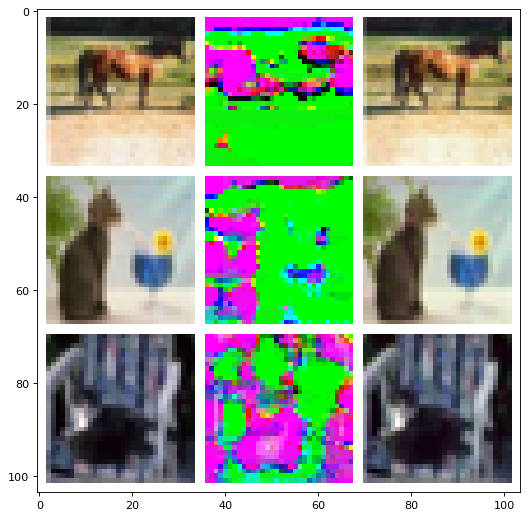

In [6]:
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def imshow(img):
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def get_pairs_of_imgs(idx):
    clean_img = clean_train_dataset.data[idx]
    unlearnable_img = unlearnable_train_dataset.data[idx]
    clean_img = torchvision.transforms.functional.to_tensor(clean_img)
    unlearnable_img = torchvision.transforms.functional.to_tensor(unlearnable_img)

    x = noise[idx]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    return [clean_img, noise_norm, unlearnable_img]
    
selected_idx = [random.randint(0, 50000) for _ in range(3)]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    

imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))



<h3>Train ResNet18 on Unlearnable Dataset</h3>

In [7]:
from util import AverageMeter

model = ResNet18()
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

unlearnable_loader = DataLoader(dataset=unlearnable_train_dataset, batch_size=128,
                                shuffle=True, pin_memory=True,
                                drop_last=False, num_workers=12)


for epoch in range(30):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
    for images, labels in pbar:
        images, labels = images.cuda(), labels.cuda()
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    scheduler.step()
    # Eval
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
            logits = model(images)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    tqdm.write('Clean Accuracy %.2f\n' % (acc*100))
            

Acc 43.54 Loss: 1.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.51it/s]


Clean Accuracy 24.41



Acc 84.08 Loss: 0.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.02it/s]


Clean Accuracy 21.01



Acc 90.69 Loss: 0.27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.71it/s]


Clean Accuracy 23.10



Acc 92.66 Loss: 0.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.05it/s]


Clean Accuracy 23.88



Acc 93.28 Loss: 0.20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.68it/s]


Clean Accuracy 25.37



Acc 94.20 Loss: 0.17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.21it/s]


Clean Accuracy 24.44



Acc 94.66 Loss: 0.16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.63it/s]


Clean Accuracy 21.89



Acc 95.02 Loss: 0.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.63it/s]


Clean Accuracy 25.04



Acc 95.32 Loss: 0.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.63it/s]


Clean Accuracy 22.92



Acc 95.40 Loss: 0.13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.71it/s]


Clean Accuracy 23.44



Acc 95.86 Loss: 0.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.28it/s]


Clean Accuracy 26.63



Acc 96.14 Loss: 0.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.56it/s]


Clean Accuracy 24.76



Acc 96.10 Loss: 0.11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.39it/s]


Clean Accuracy 24.18



Acc 96.54 Loss: 0.10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.68it/s]


Clean Accuracy 24.93



Acc 96.89 Loss: 0.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.69it/s]


Clean Accuracy 23.29



Acc 97.24 Loss: 0.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.45it/s]


Clean Accuracy 24.38



Acc 97.28 Loss: 0.08: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.41it/s]


Clean Accuracy 25.61



Acc 97.60 Loss: 0.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.26it/s]


Clean Accuracy 25.52



Acc 97.95 Loss: 0.06: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.10it/s]


Clean Accuracy 28.61



Acc 98.09 Loss: 0.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.39it/s]


Clean Accuracy 26.20



Acc 98.49 Loss: 0.05: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.24it/s]


Clean Accuracy 28.78



Acc 98.81 Loss: 0.04: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.77it/s]


Clean Accuracy 28.59



Acc 98.97 Loss: 0.03: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.21it/s]


Clean Accuracy 29.43



Acc 99.28 Loss: 0.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.99it/s]


Clean Accuracy 29.56



Acc 99.41 Loss: 0.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.05it/s]


Clean Accuracy 30.29



Acc 99.61 Loss: 0.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.72it/s]


Clean Accuracy 27.89



Acc 99.70 Loss: 0.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.55it/s]


Clean Accuracy 30.57



Acc 99.70 Loss: 0.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.68it/s]


Clean Accuracy 32.18



Acc 99.81 Loss: 0.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.63it/s]


Clean Accuracy 30.00



Acc 99.81 Loss: 0.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.58it/s]


Clean Accuracy 31.43

